In [547]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [312]:
with open('uke_eggedal_data_challenge.pkl', 'rb') as f:
    data_dict = pickle.load(f)
## summarize data in pickle file
#for k, v in data_dict.items():
    #print(k)
    #print(type(v))
    #try:
        #print(v.shape)
    #except AttributeError:
        #print(len(v))
## create dataframe with flow data
flow_df = pd.DataFrame(data=data_dict['flow'], index=data_dict['flow_dates'], 
                       columns=['flow'])
## column names
n_locs = data_dict['obs_pr'].shape[1]
tas_cols = ['tas_{:d}'.format(i) for i in range(n_locs)]
pr_cols = ['pr_{:d}'.format(i) for i in range(n_locs)]
## create dataframes for temperature and precipitation data
tas_df = pd.DataFrame(data=data_dict['obs_tas'], index=data_dict['obs_dates'], 
                      columns=tas_cols)
pr_df = pd.DataFrame(data=data_dict['obs_pr'], index=data_dict['obs_dates'], 
                     columns=pr_cols)
## create one dataframe for all data
df = pd.concat((tas_df, pr_df, flow_df), join='inner', axis=1)
#print(df.head())
#print(df.shape)

### Descriptions of dataset
* tas_df: temperature observations of 9 locations
* pr_df: precipitation observations of 9 locations
* flow_df: the response variable that we need to fit and predict
* Time: from 1958-01-04 to 2015-12-31 daily data of 21778 days


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21178 entries, 1958-01-04 to 2015-12-31
Data columns (total 19 columns):
tas_0    21178 non-null float64
tas_1    21178 non-null float64
tas_2    21178 non-null float64
tas_3    21178 non-null float64
tas_4    21178 non-null float64
tas_5    21178 non-null float64
tas_6    21178 non-null float64
tas_7    21178 non-null float64
tas_8    21178 non-null float64
pr_0     21178 non-null float64
pr_1     21178 non-null float64
pr_2     21178 non-null float64
pr_3     21178 non-null float64
pr_4     21178 non-null float64
pr_5     21178 non-null float64
pr_6     21178 non-null float64
pr_7     21178 non-null float64
pr_8     21178 non-null float64
flow     21178 non-null float64
dtypes: float64(19)
memory usage: 3.2 MB


In [42]:
df.describe()

tas_0         tas_1         tas_2         tas_3         tas_4  \
count  21178.000000  21178.000000  21178.000000  21178.000000  21178.000000   
mean      -0.047006      0.714643      2.979516      1.489362      1.274884   
std        8.261391      8.396938      9.050337      8.571648      8.467370   
min      -33.799999    -32.599998    -33.299999    -33.700001    -32.799999   
25%       -5.800000     -5.200000     -3.100000     -4.400000     -4.600000   
50%        0.200000      0.900000      3.400000      1.800000      1.500000   
75%        6.600000      7.600000     10.600000      8.500000      8.200000   
max       20.299999     21.200001     23.400000     21.700001     21.700001   

              tas_5         tas_6         tas_7         tas_8          pr_0  \
count  21178.000000  21178.000000  21178.000000  21178.000000  21178.000000   
mean       2.313594      1.890589      2.839834      3.527821      1.991529   
std        8.613825      8.575300      8.797301      8.959525      4.025939   
min      -32.200001    -33.200001    -32.599998    -30.799999      0.000000   
25%       -3.700000     -4.000000     -3.200000     -2.600000      0.000000   
50%        2.500000      2.200000      3.100000      3.700000      0.000000   
75%        9.500000      9.000000     10.200000     11.100000      2.500000   
max       22.700001     21.799999     23.299999     24.000000     61.500000   

               pr_1          pr_2          pr_3          pr_4          pr_5  \
count  21178.000000  21178.000000  21178.000000  21178.000000  21178.000000   
mean       2.007583      2.076490      2.213070      2.265171      2.214652   
std        4.347522      4.496716      4.560043      4.756833      4.908967   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        2.200000      2.200000      2.600000      2.600000      2.200000   
max       60.700001     66.800003     64.000000     62.400002     61.299999   

               pr_6          pr_7          pr_8          flow  
count  21178.000000  21178.000000  21178.000000  21178.000000  
mean       2.305860      2.385376      2.255959      6.914146  
std        4.807279      5.424111      5.184413      9.665353  
min        0.000000      0.000000      0.000000      0.000031  
25%        0.000000      0.000000      0.000000      1.156123  
50%        0.000000      0.000000      0.000000      3.151342  
75%        2.600000      2.200000      2.000000      8.606681  
max       64.500000     67.699997     73.699997     85.397653

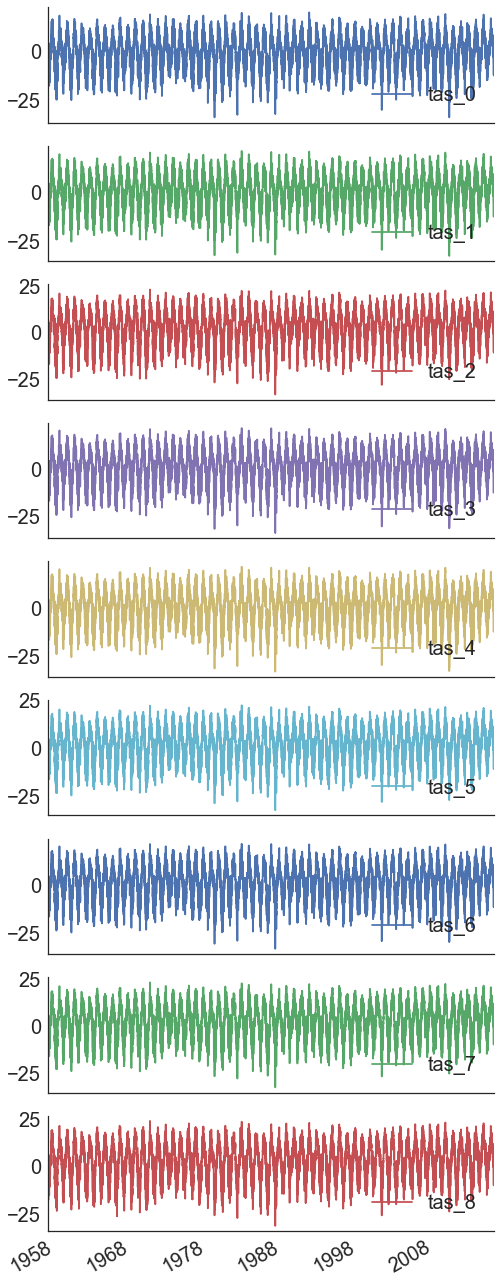

In [79]:
# timeseries normalized?
# strong annual cycle embedded >> need to remove before any fitting
# any trends?
tas_df.plot(subplots=True, layout=(9, 1), figsize=(8, 25), sharex=True)  # certainly not normalized
sns.despine()#)
plt.show()

In [90]:
tas_df[tas_df['tas_0']>20]

tas_0      tas_1  tas_2      tas_3      tas_4  tas_5  \
1982-08-03  20.100000  21.200001   21.9  21.700001  21.700001   22.5   
1991-07-08  20.299999  20.900000   22.4  21.299999  21.200001   22.0   

                tas_6  tas_7      tas_8  
1982-08-03  21.799999   21.9  22.700001  
1991-07-08  21.500000   22.4  23.000000

In [88]:
tas_df[tas_df['tas_0']<-30]
# The cold days seem quite universal across locations, for example, 1987-01-10 to 1987-01-11, and 1978-12-31 to 1979-01-01
# The cold days seem quite universal across locations, for example, 1987-01-10 to 1987-01-11, and 1978-12-31 to 1979-01-01

tas_0      tas_1      tas_2      tas_3      tas_4      tas_5  \
1978-12-31 -31.799999 -30.600000 -25.900000 -29.600000 -29.500000 -27.200001   
1979-01-01 -33.799999 -32.299999 -26.799999 -31.500000 -31.200001 -28.600000   
1982-01-08 -32.500000 -31.000000 -27.299999 -29.700001 -29.900000 -27.600000   
1987-01-10 -30.299999 -29.500000 -26.900000 -28.200001 -28.200001 -27.700001   
1987-01-11 -32.099998 -31.900000 -33.299999 -33.700001 -32.799999 -32.200001   
2010-01-09 -33.799999 -32.599998 -23.600000 -31.200001 -32.500000 -26.799999   

                tas_6      tas_7      tas_8  
1978-12-31 -28.500000 -25.100000 -23.600000  
1979-01-01 -30.600000 -26.700001 -25.299999  
1982-01-08 -29.000000 -27.900000 -26.700001  
1987-01-10 -27.500000 -26.700001 -26.000000  
1987-01-11 -33.200001 -32.599998 -30.799999  
2010-01-09 -29.700001 -25.299999 -23.299999

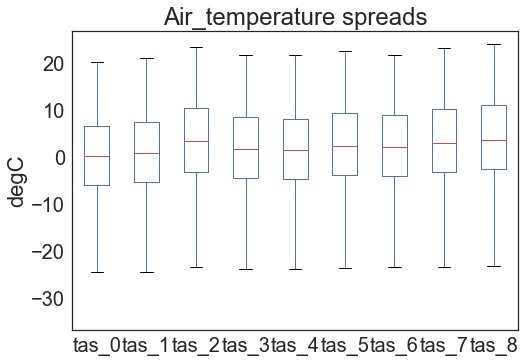

In [103]:
#label=['Loc1','Loc2','Loc3','Loc4','Loc5','Loc6','Loc7','Loc8','Loc9']
ax=tas_df.plot(kind='box')
#ax.set_xticklabels(label,ha='center')
#ax = sns.boxplot(data=tas_df)
plt.title('Air_temperature spreads')
plt.ylabel('degC')
plt.show()

In [94]:
tas_df.corr() ## very high correlation because they share a similar annual cycle, 
## The air_temperatures between locations appear to correlate pretty well. 

tas_0     tas_1     tas_2     tas_3     tas_4     tas_5     tas_6  \
tas_0  1.000000  0.998961  0.977102  0.996461  0.997470  0.990438  0.994347   
tas_1  0.998961  1.000000  0.982934  0.998647  0.999481  0.994893  0.997278   
tas_2  0.977102  0.982934  1.000000  0.988455  0.986177  0.993120  0.991115   
tas_3  0.996461  0.998647  0.988455  1.000000  0.999552  0.996875  0.999490   
tas_4  0.997470  0.999481  0.986177  0.999552  1.000000  0.996769  0.998841   
tas_5  0.990438  0.994893  0.993120  0.996875  0.996769  1.000000  0.998108   
tas_6  0.994347  0.997278  0.991115  0.999490  0.998841  0.998108  1.000000   
tas_7  0.982094  0.987590  0.998222  0.991545  0.990496  0.996892  0.994139   
tas_8  0.971060  0.977901  0.996420  0.982327  0.981370  0.991014  0.985866   

          tas_7     tas_8  
tas_0  0.982094  0.971060  
tas_1  0.987590  0.977901  
tas_2  0.998222  0.996420  
tas_3  0.991545  0.982327  
tas_4  0.990496  0.981370  
tas_5  0.996892  0.991014  
tas_6  0.994139  0.985866  
tas_7  1.000000  0.996982  
tas_8  0.996982  1.000000

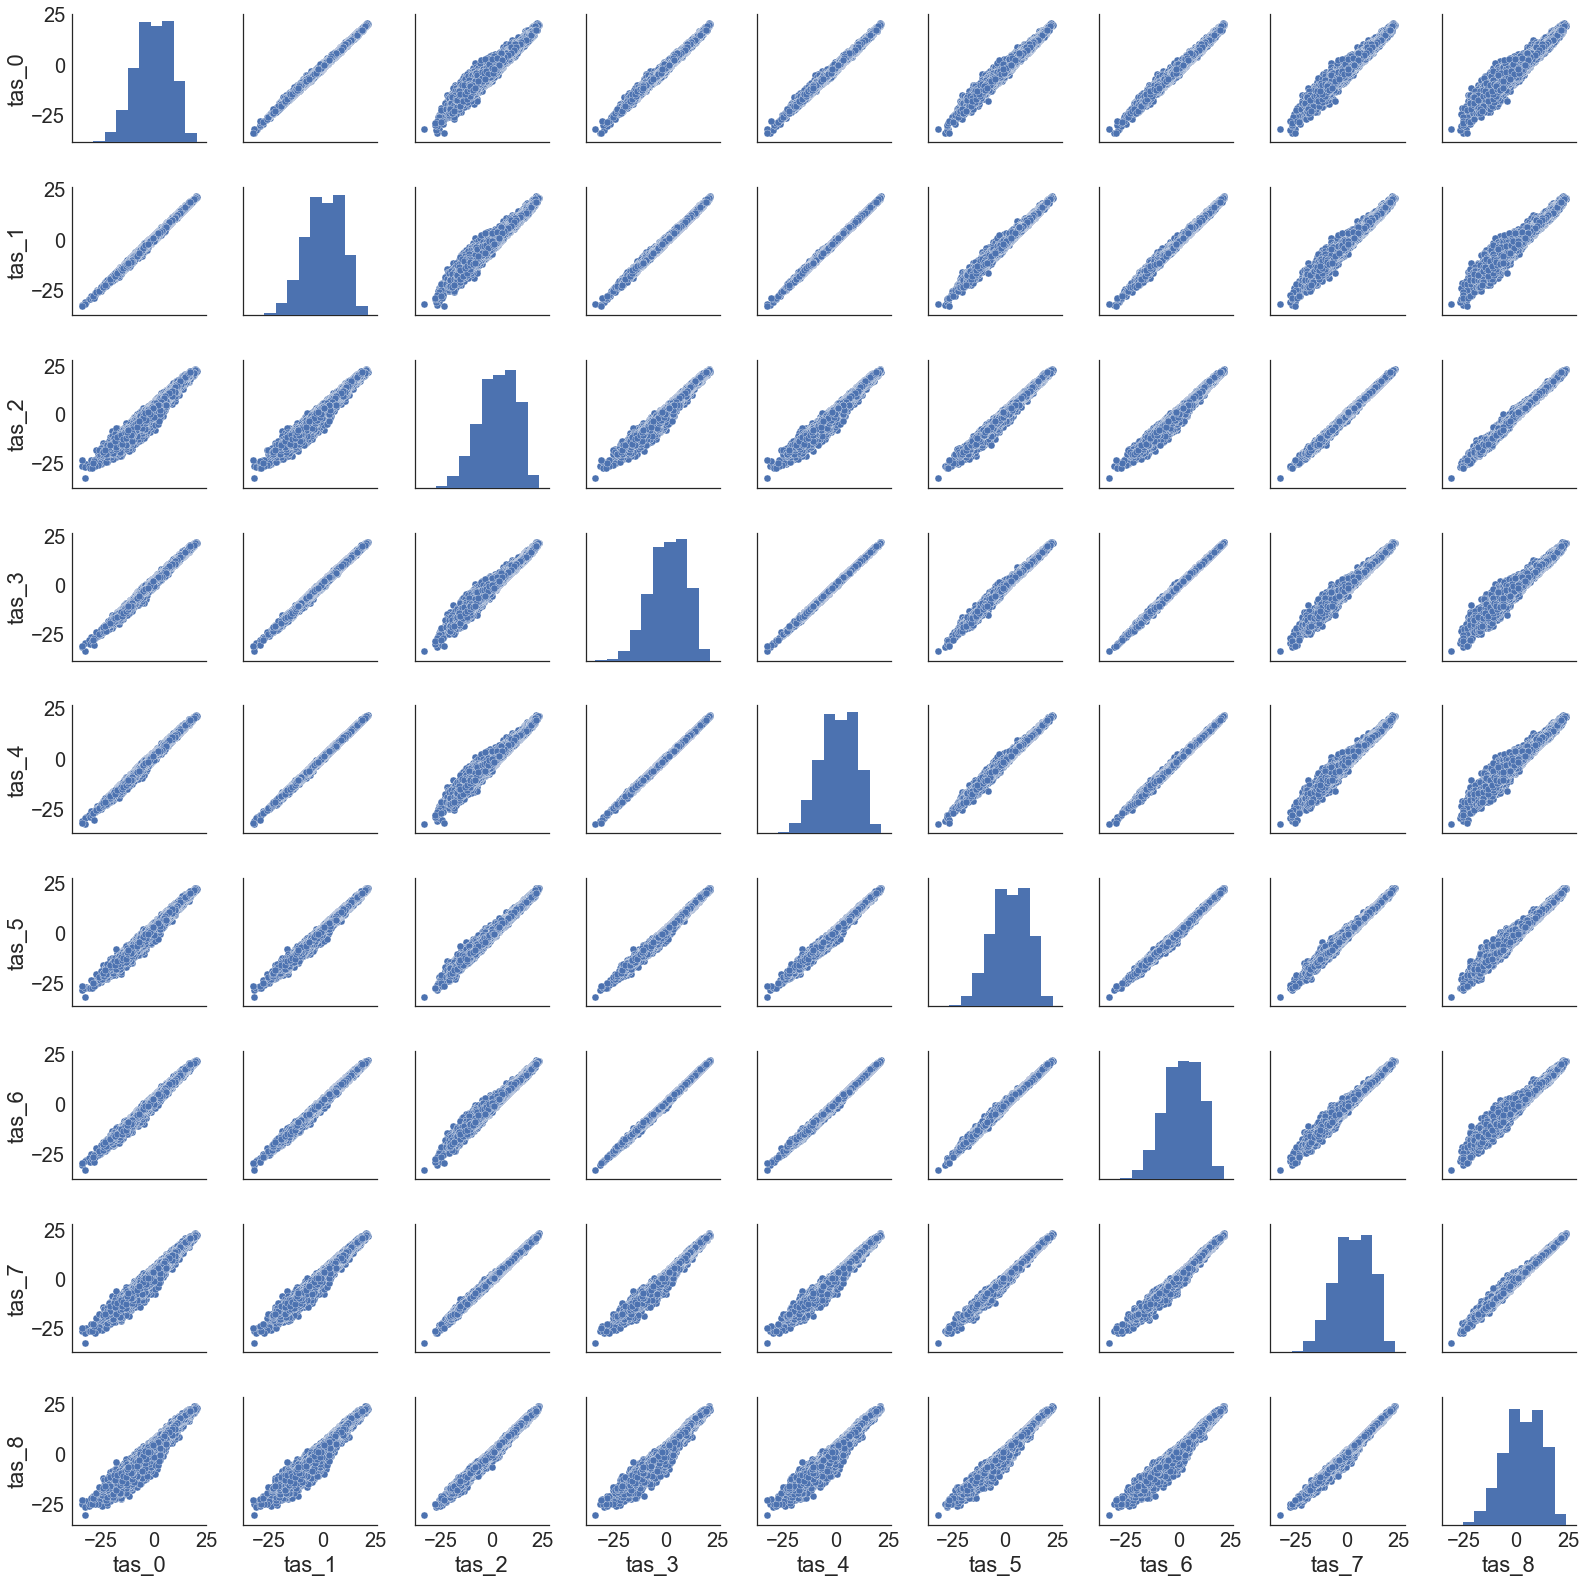

In [99]:
sns.pairplot(tas_df)

In [13]:
# Remove seasonal cycle then estimate correlation
climatology=tas_df.groupby(tas_df.index.month).mean()
climatology.plot() ## seasonal cycle

In [14]:
anomaly = lambda x: (x - x.mean()) 
deseasoned_tas=tas_df.groupby(tas_df.index.month).transform(anomaly)

In [27]:
tas_df['tas_0']['1960':'1965'].plot()

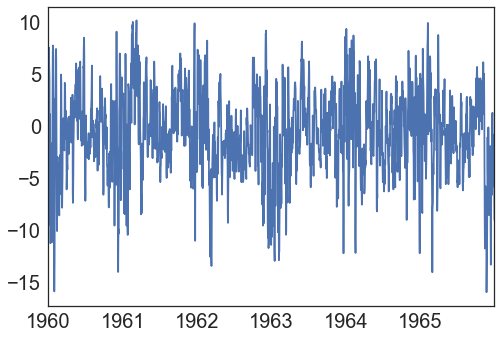

In [26]:
deseasoned_tas['tas_0']['1960':'1965'].plot()

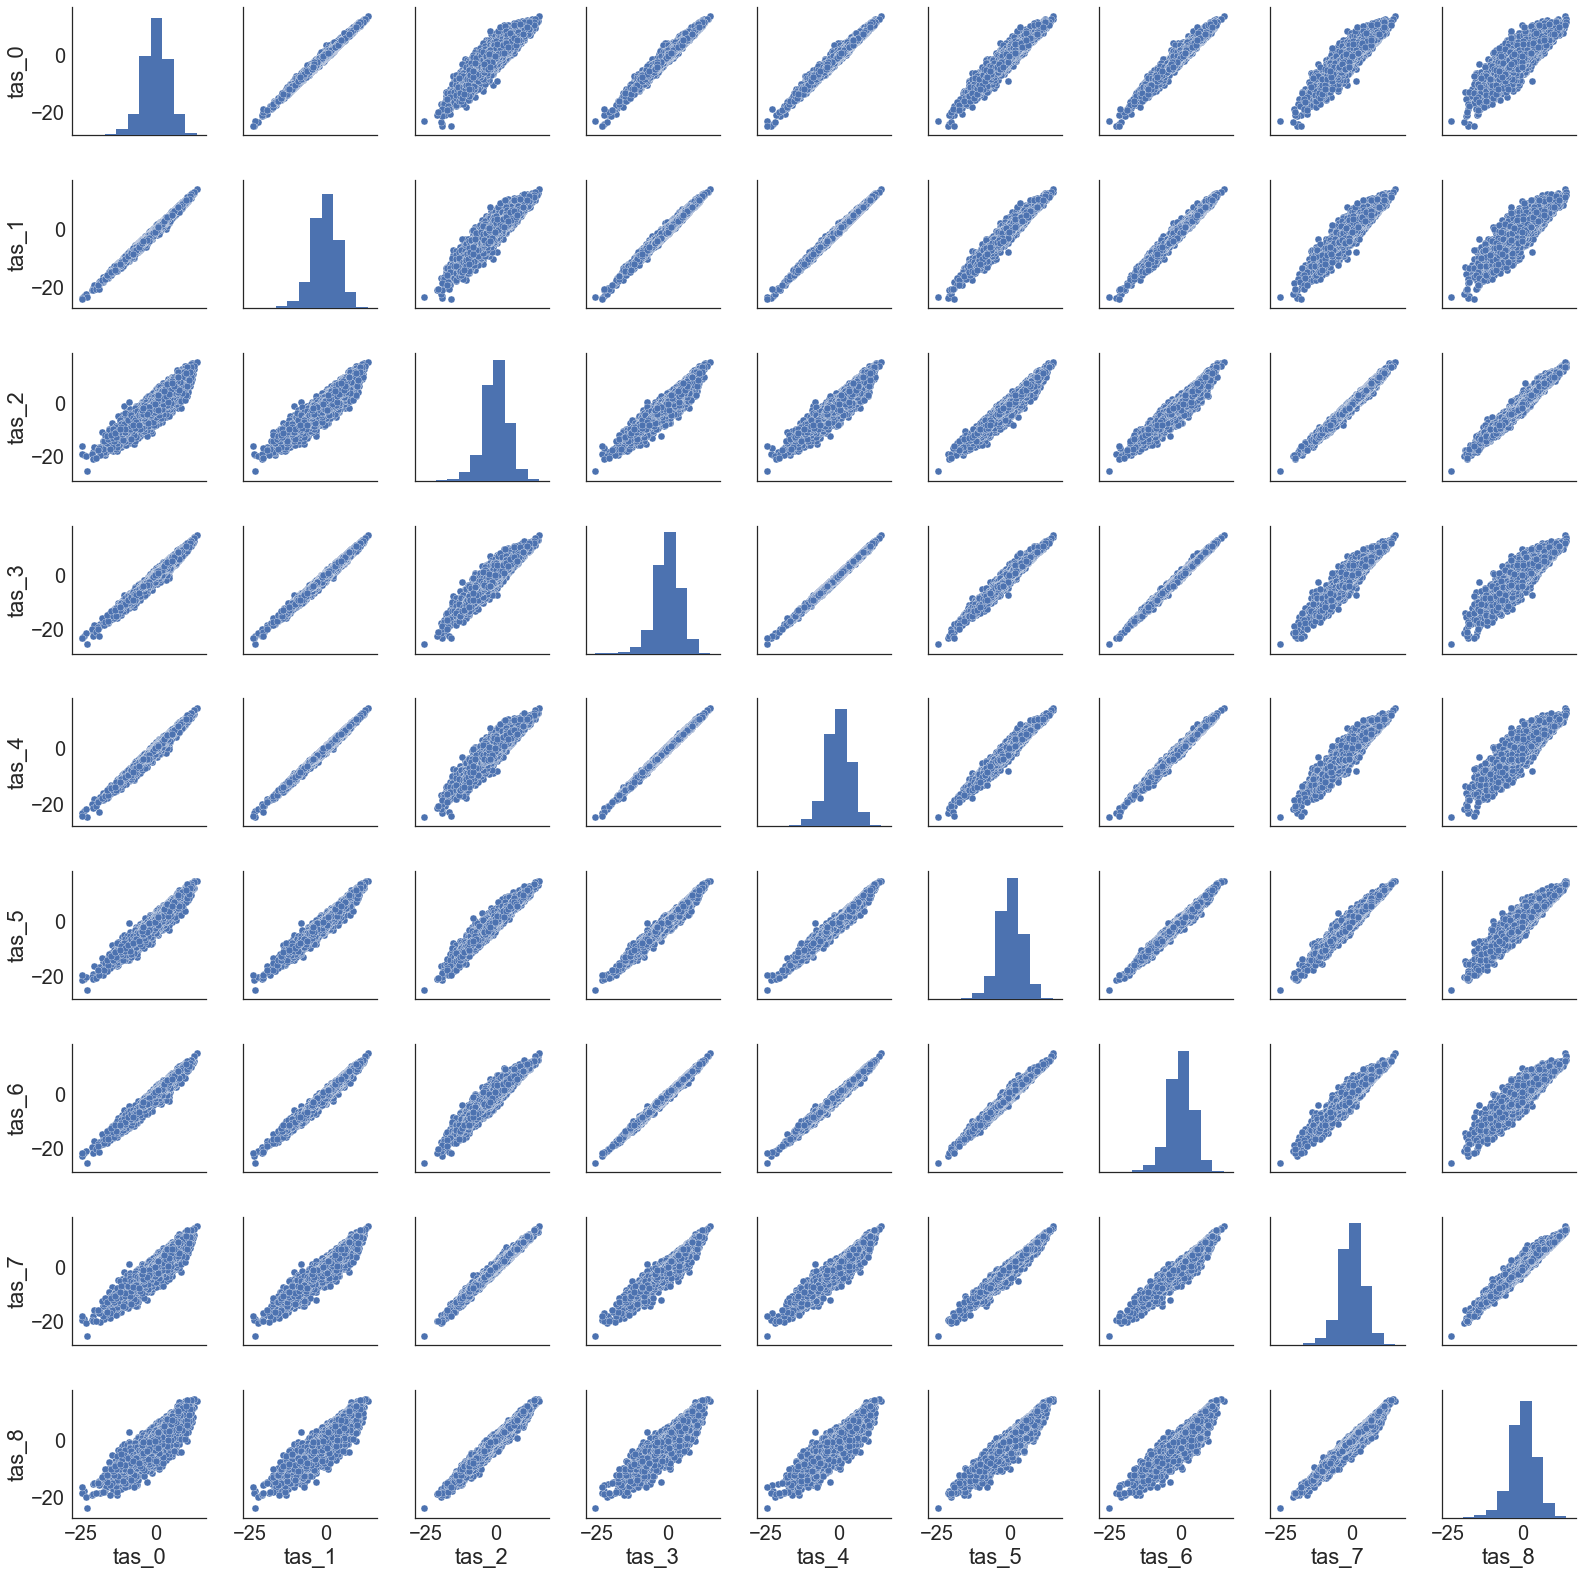

In [28]:
sns.pairplot(deseasoned_tas)

In [29]:
deseasoned_tas.corr()

tas_0     tas_1     tas_2     tas_3     tas_4     tas_5     tas_6  \
tas_0  1.000000  0.996964  0.924950  0.988855  0.992109  0.968863  0.981680   
tas_1  0.996964  1.000000  0.940546  0.995158  0.998128  0.982121  0.990185   
tas_2  0.924950  0.940546  1.000000  0.959395  0.951193  0.973911  0.968452   
tas_3  0.988855  0.995158  0.959395  1.000000  0.998353  0.988802  0.998118   
tas_4  0.992109  0.998128  0.951193  0.998353  1.000000  0.988546  0.995727   
tas_5  0.968863  0.982121  0.973911  0.988802  0.988546  1.000000  0.993044   
tas_6  0.981680  0.990185  0.968452  0.998118  0.995727  0.993044  1.000000   
tas_7  0.939819  0.955442  0.993253  0.969132  0.965370  0.987592  0.978340   
tas_8  0.899106  0.918523  0.985519  0.933780  0.930298  0.963742  0.946314   

          tas_7     tas_8  
tas_0  0.939819  0.899106  
tas_1  0.955442  0.918523  
tas_2  0.993253  0.985519  
tas_3  0.969132  0.933780  
tas_4  0.965370  0.930298  
tas_5  0.987592  0.963742  
tas_6  0.978340  0.946314  
tas_7  1.000000  0.987610  
tas_8  0.987610  1.000000

### Linear trends in time

In [114]:
import statsmodels.api as sm
def linTrend(TS):
    days=range(len(TS))
    results=sm.OLS(TS,sm.add_constant(days)).fit()
    return results.params.x1
    

In [538]:
deseasoned_df.apply(linTrend)*365*10

tas_0    0.230259
tas_1    0.245758
tas_2    0.348280
tas_3    0.250211
tas_4    0.252066
tas_5    0.296777
tas_6    0.263369
tas_7    0.340650
tas_8    0.419416
pr_0     0.043812
pr_1     0.043798
pr_2     0.057806
pr_3     0.062067
pr_4     0.055505
pr_5     0.033106
pr_6     0.044956
pr_7     0.034719
pr_8     0.029534
flow     0.152001
dtype: float64

In [124]:
deseasoned_tas.apply(linTrend)*365*10

tas_0    0.219767
tas_1    0.235617
tas_2    0.336338
tas_3    0.240214
tas_4    0.241911
tas_5    0.288001
tas_6    0.253079
tas_7    0.327874
tas_8    0.405978
dtype: float64

In [84]:
import statsmodels.api as sm
days=range(len(deseasoned_tas['tas_0']))
results = sm.OLS(deseasoned_tas['tas_0'],sm.add_constant(days)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tas_0   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     167.4
Date:                Fri, 18 May 2018   Prob (F-statistic):           3.78e-38
Time:                        17:19:59   Log-Likelihood:                -61740.
No. Observations:               21546   AIC:                         1.235e+05
Df Residuals:                   21544   BIC:                         1.235e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6486      0.058    -11.205      0.000      -0.762      -0.535
x1          6.021e-05   4.65e-06     12.939      0.000    5.11e-05    6.93e-05
==============================================================================
Omnibus:                      881.398   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.871
Skew:                          -0.399   Prob(JB):                    1.08e-276
Kurtosis:                       3.883   Cond. No.                     2.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Precipitation

In [78]:
pr_df.plot(subplots=True, layout=(9, 1), figsize=(8, 25), sharex=True)  # certainly not normalized
sns.despine()#)
plt.show()

In [127]:
# Remove seasonal cycle then estimate correlation
climatology_pr=pr_df.groupby(pr_df.index.month).mean()
climatology_pr.plot() ## seasonal cycle

# Most precipitation occurs in Summer, peaks in July, August, but remain high till November
# Lowest precipitation in February till April

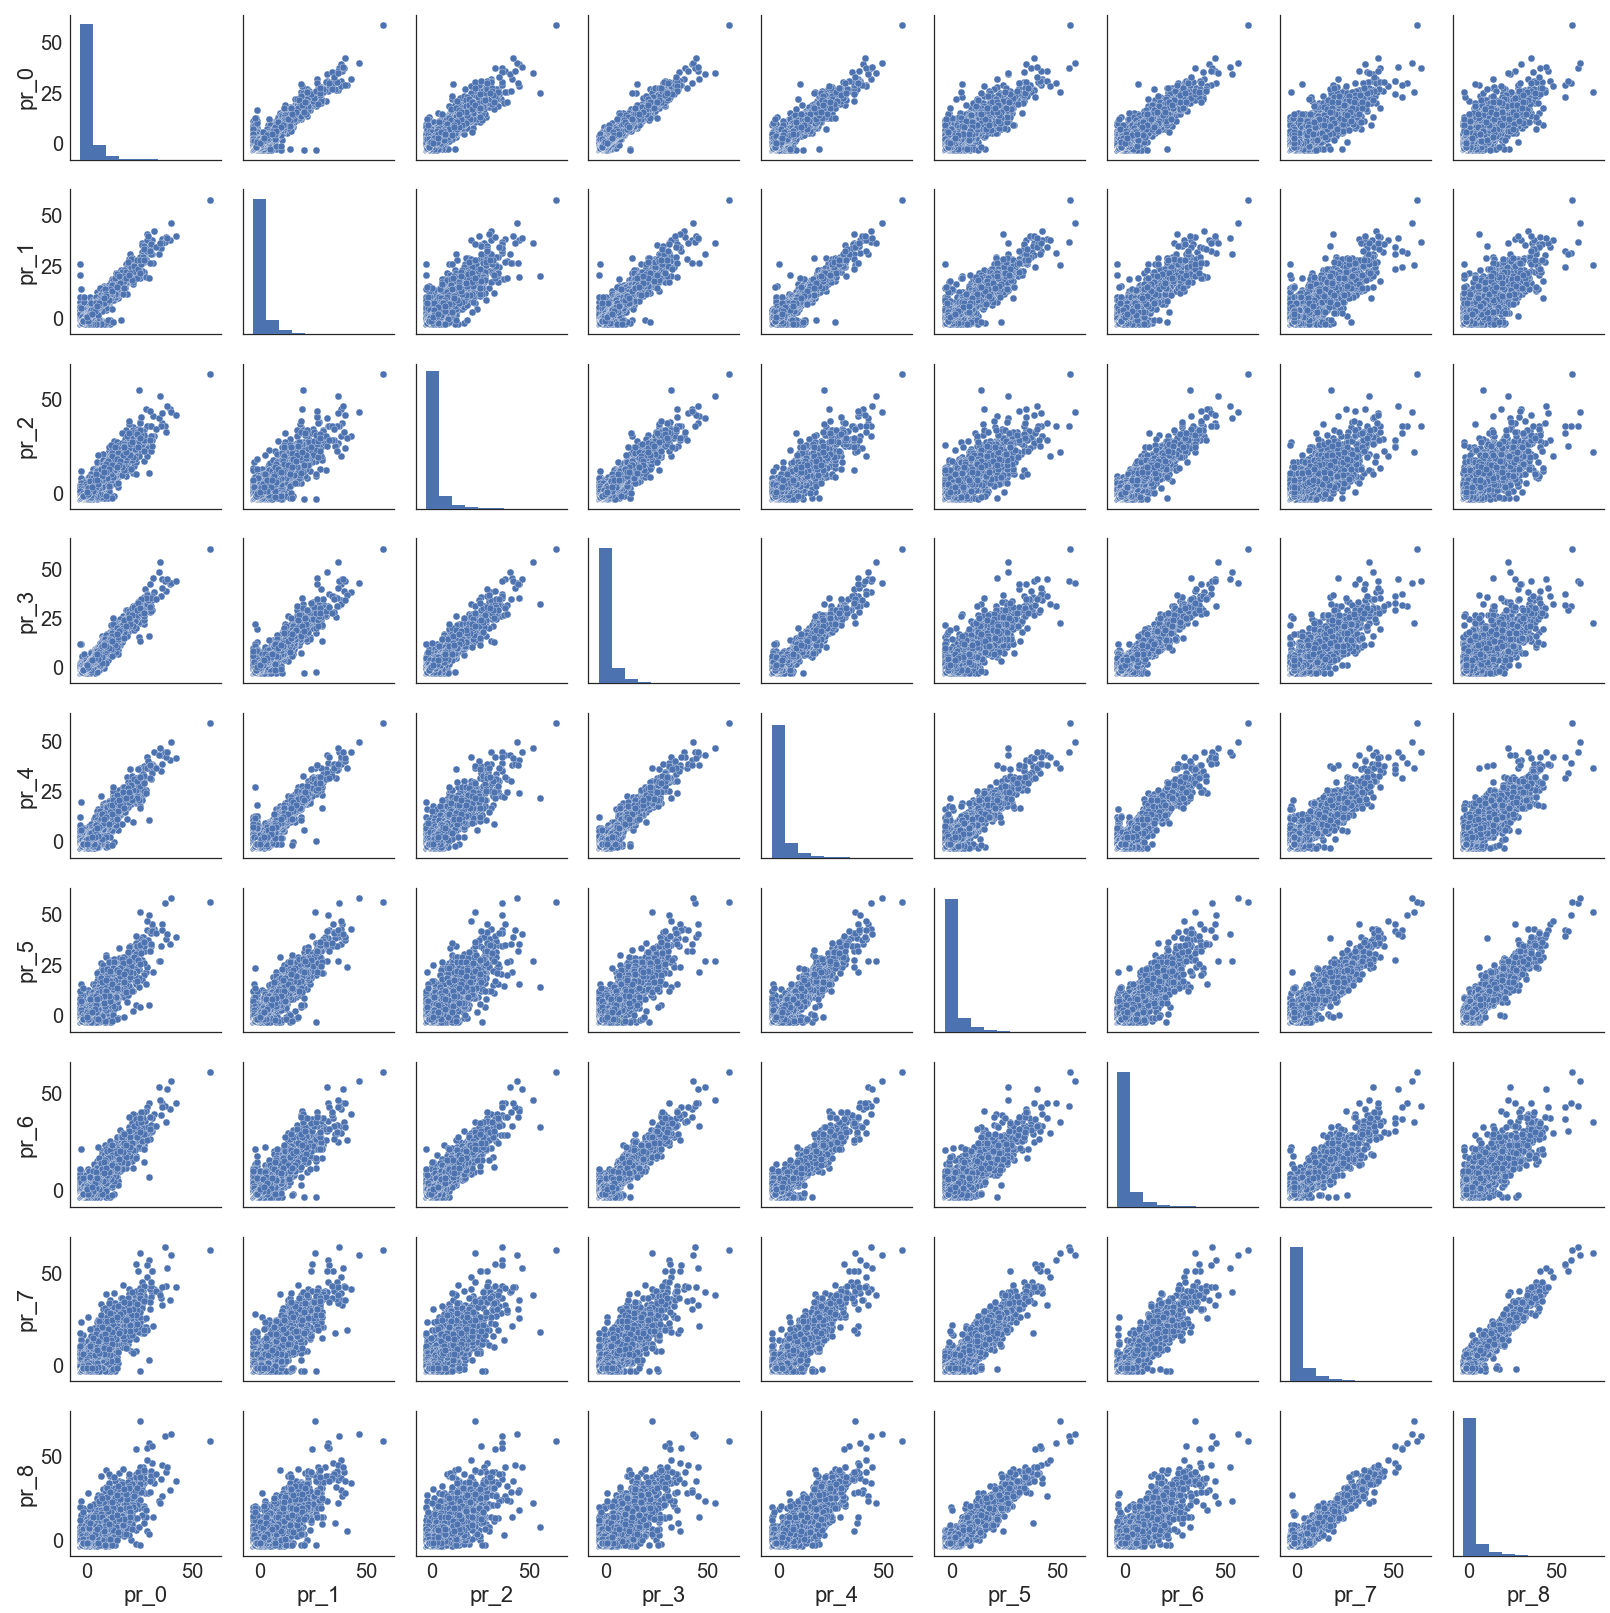

In [129]:
anomaly2 = lambda x: (x - x.mean()) 
deseasoned_pr=pr_df.groupby(pr_df.index.month).transform(anomaly2)
sns.pairplot(deseasoned_pr)

In [131]:
deseasoned_pr.corr() 

pr_0      pr_1      pr_2      pr_3      pr_4      pr_5      pr_6  \
pr_0  1.000000  0.958949  0.939546  0.976114  0.956432  0.912548  0.939635   
pr_1  0.958949  1.000000  0.907316  0.951497  0.966899  0.941098  0.926716   
pr_2  0.939546  0.907316  1.000000  0.956738  0.921916  0.882822  0.944564   
pr_3  0.976114  0.951497  0.956738  1.000000  0.973665  0.915369  0.966802   
pr_4  0.956432  0.966899  0.921916  0.973665  1.000000  0.961864  0.962752   
pr_5  0.912548  0.941098  0.882822  0.915369  0.961864  1.000000  0.931280   
pr_6  0.939635  0.926716  0.944564  0.966802  0.962752  0.931280  1.000000   
pr_7  0.891978  0.900714  0.872662  0.904930  0.949174  0.959062  0.948029   
pr_8  0.858680  0.872317  0.827994  0.856926  0.916201  0.960785  0.900194   

          pr_7      pr_8  
pr_0  0.891978  0.858680  
pr_1  0.900714  0.872317  
pr_2  0.872662  0.827994  
pr_3  0.904930  0.856926  
pr_4  0.949174  0.916201  
pr_5  0.959062  0.960785  
pr_6  0.948029  0.900194  
pr_7  1.000000  0.975936  
pr_8  0.975936  1.000000

In [132]:
deseasoned_pr.apply(linTrend)*365*10 #also a positive trends in precipitation in all locations

pr_0    0.041264
pr_1    0.042278
pr_2    0.057685
pr_3    0.059515
pr_4    0.052664
pr_5    0.031307
pr_6    0.044357
pr_7    0.034299
pr_8    0.026846
dtype: float64

### Precipitation Summary
* Location 6-9 have high correlation, especially the high precip events in the first decade
* All locations have a high precip peak on 1994-08-14

In [138]:
df_noflow=df.drop(['flow'], axis=1)
deseasoned_df=df_noflow.groupby(df_noflow.index.month).transform(anomaly2)

### Correlation of deseasoned data

In [141]:
sns.pairplot(deseasoned_df)

In [157]:
for TS1, TS2 in zip(pr_df.columns, tas_df.columns):
    print(deseasoned_pr[TS1].corr(deseasoned_tas[TS2])) 
# After removing seasonal cycles, the correlations between rainfall and temperature at each location is very low.

0.000950865230372
-0.0011919544031
0.0462636666566
0.0148825906277
0.00181830664459
0.00199986649784
0.006312094835
0.0130738012289
0.0216622688317


### River Flow
* Trend of the flow
* Seasonal cycle of the flow (should be one close to Precip)
* Find the location with greatest correlation with the Flow


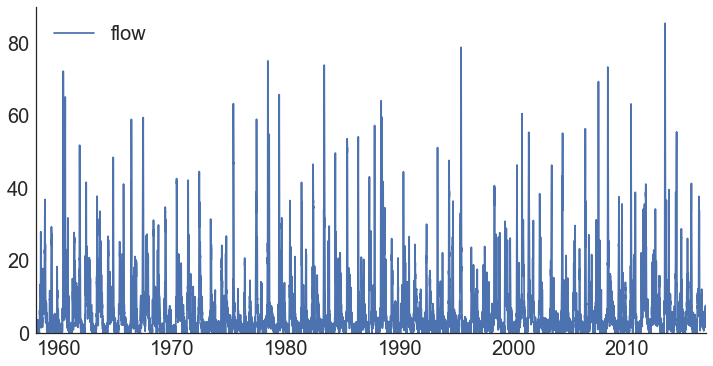

In [20]:
# Looks very much like my Agulhas leakage timeseries.
sns.set(font_scale=2)
sns.set_style(style='white')
fig=plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
# the size of A4 paper
flow_df.plot(ax=ax) #
plt.ylim([0,90])
sns.despine()#)
plt.show()

In [360]:
# Remove seasonal cycle then estimate correlation
climatology_fl=flow_df.groupby(flow_df.index.month).mean()
climatology_fl.plot() ## seasonal cycle
# Highest river flow events in May.


### Spectral analysis of flow

In [560]:
from mtspec.multitaper import mtspec
PSD,f=mtspec(flow_df, 1, 4, number_of_tapers=7)

Text(0.5,0,'Frequency(cycles/day)')

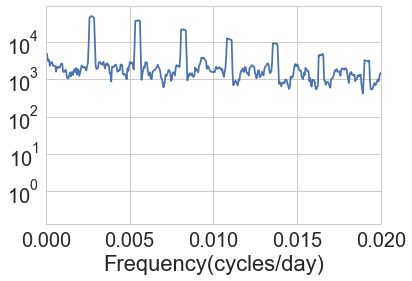

In [562]:
sns.set_style('whitegrid')
plt.semilogy(f,PSD)
plt.xlim([0,0.02]) # 0.5 
plt.xlabel('Frequency(cycles/day)')

## Summary of the findings:
* Strong seasonal signals in precipitation, temperature in all locations, as well as the flow 
* But the Tas and Pr peak in Summer (June to August), yet the Flow peaks in May
* All have positive linear trends in times, but not sure if such trends are significant (0.3deg/decade, 0.04mm/decade, 0.15m^3/decade).
* Low correlation between precipitation and temperature at same locations
* But high correlation among Temperature/precipittions among different locations, respectively.
* Correlation between tas and flow ~0.3, precip and flow ~0.2

### Machine learning model > use 18 features to predict the river flow
* Try simple regression first (multivariate)
* Remove co-linearity between precip/temp
* Normalize/remove seasonal cycle before fitting
* Feature engineering, regularization
* Evaluate model performance

### Naive approach, full dataframe

In [370]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(noflow, df['flow'], test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test) 
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

### How to improve?
* Scaling the features
* cross-validation
* Regularization
* hyperparameter tuning use GridSearchCV
* remove seasonal cycle from the dataset
* Try different algorithms?

In [443]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(noflow, df['flow'], test_size=0.3, random_state=0)

steps = [('scaler', StandardScaler()),
        ('reg', LinearRegression())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Show scores:
from sklearn.model_selection import cross_val_score
cv_results=cross_val_score(pipeline,X_train, y_train,cv=5)
print(cv_results)

[ 0.16873677  0.16866896  0.15773643  0.17143275  0.16186534]


In [433]:
# Regularization Ridge Regression
from sklearn.linear_model import Ridge
steps2 = [('scaler', StandardScaler()),
        ('Ridge', Ridge(alpha=0.1,normalize=True))]

# Create the pipeline: pipeline
pipeline2 = Pipeline(steps2)
pipeline2.fit(X_train, y_train)

# Show scores:
cv_results=cross_val_score(pipeline2,X_train, y_train,cv=5)
print(cv_results)

[ 0.15012499  0.15650191  0.14435971  0.16003823  0.14207848]


[ 0.15015452  0.15669041  0.14482133  0.16032624  0.14184065]


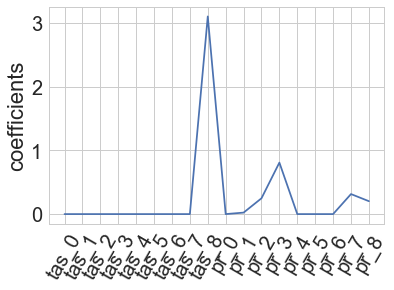

In [444]:
# Regularization Lasso Regression
from sklearn.linear_model import Lasso
steps3 = [('scaler', StandardScaler()),
        ('Lasso', Lasso(alpha=0.1))]
# Create the pipeline: pipeline
pipeline3 = Pipeline(steps3)
pipeline3.fit(X_train, y_train)

# Show scores:
cv_results=cross_val_score(pipeline3,X_train, y_train,cv=5)
print(cv_results)

# Most important features:
Lasso_coef=pipeline3.named_steps['Lasso'].coef_
names=noflow.columns
_=plt.plot(range(len(names)),Lasso_coef)
_=plt.xticks(range(len(names)),names,rotation=60)
_=plt.ylabel('coefficients')
plt.show()

# Seems tas8, pr3, pr7, pr8 most representative for flow prediction.

In [435]:
# Remove Seasonal cycle
anomaly = lambda x: (x - x.mean()) 
deseasoned_df=df.groupby(df.index.month).transform(anomaly)
deseasoned_noflow=deseasoned_df.drop(['flow'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(deseasoned_noflow, deseasoned_df['flow'], test_size=0.3, random_state=0)

pipeline3.fit(X_train, y_train)
# Show scores:
from sklearn.model_selection import cross_val_score
cv_results=cross_val_score(pipeline3,X_train, y_train,cv=5)
print(cv_results) 

# For all three Linear Regression, the R^2 score reduces significantly after removing seasonal cycle

[ 0.07377393  0.07656659  0.06354876  0.08314756  0.07317459]


In [426]:
import numpy as np
from sklearn.metrics import mean_squared_error
y_pred=pipeline3.predict(X_test)
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 7.2037


In [463]:
# Use GridSearchCV to tune hyperparameters
from sklearn.model_selection import GridSearchCV
param_grid={'Lasso__alpha':np.linspace(0.1,2,20)}
lasso_cv=GridSearchCV(pipeline3,param_grid,cv=5)
lasso_cv.fit(X_train,y_train)
lasso_cv.best_score_

0.15076723082521856

### Random Forest

In [468]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(noflow, df['flow'], test_size=0.3, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(deseasoned_noflow, deseasoned_df['flow'], test_size=0.3, random_state=0)

steps = [('scaler', StandardScaler()),
        ('forest', RandomForestRegressor(random_state=42))]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Random Forest R squared": %.4f' % pipeline.score(X_test, y_test))

Random Forest R squared": 0.2296


### Gradient Boosting

In [471]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(noflow, df['flow'], test_size=0.3, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(deseasoned_noflow, deseasoned_df['flow'], test_size=0.3, random_state=0)

steps = [('scaler', StandardScaler()),
        ('gb', GradientBoostingRegressor())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Gradient Boost R squared": %.4f' % pipeline.score(X_test, y_test))

Gradient Boost R squared": 0.3144


## Different Approach: Classification of high-flow events rather than regression
* Labeling df['flow'] by prescribing a threshold
* Try KNN and Logistic

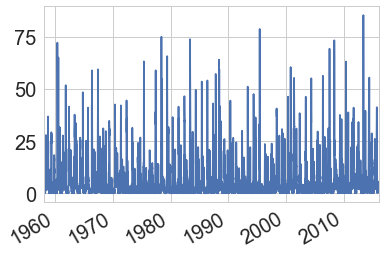

In [472]:
df['flow'].plot()

In [475]:
df['flow'].describe(percentiles=[.25, .5, .75,.90,.95])

count    21178.000000
mean         6.914146
std          9.665353
min          0.000031
25%          1.156123
50%          3.151342
75%          8.606681
90%         18.567199
95%         26.635724
max         85.397653
Name: flow, dtype: float64

In [507]:
# Labeling for flow > 20 
df['flood'] = np.where(df['flow']>=20, 1,0)
df_labeld=df.drop(['flow','flood'], axis=1)

### KNN

In [565]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(df_labeld, df['flood'], test_size=0.3, random_state=21)

knn=KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)

y_pred=knn.predict(X_test)
y_prob=knn.predict_proba(X_test)
print(knn.score(X_test,y_test))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.907617248977
[[5721   79]
 [ 508   46]]
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      5800
          1       0.37      0.08      0.14       554

avg / total       0.87      0.91      0.88      6354



### Logistic Classification

In [514]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_labeld, df['flood'], test_size=0.3, random_state=21)
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5787   13]
 [ 541   13]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95      5800
          1       0.50      0.02      0.04       554

avg / total       0.88      0.91      0.88      6354



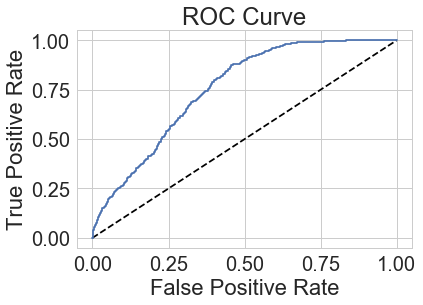

In [535]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [536]:
## ROC/AUC curve Area
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7535307481638243
AUC scores computed using 5-fold cross-validation: [ 0.78640723  0.75712391  0.76022866  0.7576233   0.7481412 ]


In [537]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_labeld, df['flood'], test_size=0.3, random_state=21)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 0.0061054022965853268, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.9106853750674582


### Next steps
* Hyperparameter tuning
* Try other algorithms, e.g. Neural Networks 
* Better way to split the data (much more non-flood days vs flood days)
* Not sure if the annual cycle should be considered. 
* Feature selection, engineering > leave out some less representative locations 

In [543]:
len(df_labeld[df['flood']==1])/len(df_labeld) # Less than 10% over 58 years of data have flow > 20m^3/sec

0.089007460572292